# Fastai with HuggingFace 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)

# Introduction : Story of transfer learning in NLP
In early 2018, Jeremy Howard (co-founder of fast.ai) and Sebastian Ruder introduced the  [Universal Language Model Fine-tuning for Text Classification](https://medium.com/r/?url=https%3A%2F%2Farxiv.org%2Fpdf%2F1801.06146.pdf) (ULMFiT) method. ULMFiT was the first **Transfer Learning** method applied to NLP. As a result, besides significantly outperforming many state-of-the-art tasks, it allowed, with only 100 labeled examples, to match performances equivalent to models trained on 100×  more data.

The first time I heard about ULMFiT was listening and following along to a [fast.ai course](https://course.fast.ai/videos/?lesson=4) given by Jeremy Howard in a class at BYU. He demonstrated how the ``fastai`` library makes the ULMFit method significantly easier to implement for someone without much code experience. In his demo, he used an AWD-LSTM neural network pre-trained on Wikitext-103 and got state-of-the-art results. He also explained key techniques to fine-tune the models like **Discriminate Learning Rate**, **Gradual Unfreezing** and **Slanted Triangular Learning Rates**.

Since the introduction of ULMFiT, **Transfer Learning** has become very popular in NLP and even Google (BERT, Transformer-XL, XLNet), Facebook (RoBERTa, XLM) and OpenAI (GPT, GPT-2) have begun to pre-train their own models on very large corpora. This time, instead of using LSTMs, they all use a more powerful architecture based on the Transformer (cf. [Attention is all you need](https://arxiv.org/abs/1706.03762)).

Although these models are powerful, ``fastai`` does not include them. Fortunately, [HuggingFace](https://huggingface.co/) 🤗 created the well-known [transformers library](https://github.com/huggingface/transformers). Formerly knew as ``pytorch-transformers`` or ``pytorch-pretrained-bert``, this library brings together over 40 state-of-the-art pre-trained NLP models (BERT, GPT-2, RoBERTa, CTRL…) implemented in PyTorch as opposed to Tensorflow, Julia, etc.. The implementation gives interesting additional utilities like pre-trained tokenizers, optimizers and configs.

The ``transformers`` library is standalone, but incorporating it with the ``fastai`` library provides a simpler implementation compatible with powerful fastai tools like  **Discriminate Learning Rate**, **Gradual Unfreezing** or **Slanted Triangular Learning Rates**. The point here is to allow anyone — expert or non-expert — to easily achieve state-of-the-art results and to “make NLP cool again”.

It worth noting that the integration of HuggingFace ``transformers`` with ``fastai`` has already been demonstrated in:
* Keita Kurita's article [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) which makes ``pytorch_pretrained_bert`` library compatible with ``fastai``.
* Dev Sharma's article [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) which makes ``pytorch_transformers`` library compatible with ``fastai``.
* N.B. Medium article ["Fastai with Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)"](https://medium.com/p/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?source=email-29c8f5cf1dc4--writer.postDistributed&sk=119c3e5d748b2827af3ea863faae6376).

Although these articles are of high quality, not all of them are currently compatible with the last version of ``transformers``, and even the last one, which this implementation is based off of in a large part is deprecated.


# 🛠 Integrating transformers with fastai for multiclass classification
Before beginning the implementation, note that integrating ``transformers`` and ``fastai`` can be done in multiple different ways. For that reason, I decided to create simple solutions, that are generic and flexible. More precisely, I try to make the minimum amount of modifications in both libraries while making them compatible with the maximum amount of transformer architectures.

Note that in addition to this NoteBook and the [Medium article](https://medium.com/p/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?source=email-29c8f5cf1dc4--writer.postDistributed&sk=119c3e5d748b2827af3ea863faae6376), I made another version available on my [GitHub](https://github.com/IMJONEZZ/).

## Libraries Installation
Before starting the implementation, you will need to install the ``fastai`` and ``transformers`` libraries. To do so, just follow the instructions [here](https://github.com/fastai/fastai/blob/master/README.md#installation) and [here](https://github.com/huggingface/transformers#installation).

In Kaggle, the ``fastai`` and ``torch`` libraries are already installed. So you just have to install ``transformers`` with :

In [1]:
%%bash
pip install transformers

  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=01bcd9613c86bb8eb57b11edd76242045689b044c61781b98b691707bee54ada
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch # This is where the models are built, and what we will use to read them.
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import * #pretrained fastai tokenizer will cooperate with our transformer tokenizer.
from fastai.callbacks import *
from fastai.tabular import * #This allows for rapid generation of visualizations.

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig #This is the one we'll be using, although it's configured to take any of them.

The current versions of the fastai, torch, and transformers libraries are respectively 1.0.58 (1.0.60 does not produce any errors), 2.4.1, and 1.3.0 (1.4.0 does not produce any errors)

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('torch version :', torch.__version__)

fastai version : 1.0.58
transformers version : 2.5.0
torch version : 1.3.0


## The example task
The given task is a multi-class text classification on [Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview).

For each text movie review, the model has to predict a label for the sentiment. We evaluate the outputs of the model on classification accuracy. The sentiment labels are:
* 0 → Negative
* 1 → Somewhat negative
* 2 → Neutral
* 3 → Somewhat positive
* 4 → Positive

This will provide a perfect context for our Library Chat analysis where the labels are:
* 0 → Dissatisfied/Frustrated
* 1 → Dissatisfied
* 2 → Neither
* 3 → Satisfied
* 4 → Above and Beyond

The data is loaded into a ``DataFrame`` using ``pandas``.

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip


In [5]:
DATA_ROOT = Path("..") / "/kaggle/input/sentiment-analysis-on-movie-reviews"
train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep="\t")
#test = pd.read_csv(DATA_ROOT / 'test.csv', index_col=0) #These are our actual datasets
#train = pd.read_csv(DATA_ROOT / 'train.csv', index_col=0)
#train.dropna()
#test.dropna()
print(train.shape,test.shape)
train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


It is worth noting that in the dataset there are no individual movie reviews but rather phrases taken out of context and split into smaller parts, each with an assigned sentiment label. 

This differs from our library dataset, where the dataset consists of entire conversations loaded at once. Here's a quick run-down:

One sentence from the Movie Reviews dataset -
* 156061	An intermittently pleasing but mostly routine effort .
* 156062	An intermittently pleasing but mostly routine effort
* 156063	An
* 156064	intermittently pleasing but mostly routine effort
* 156065	intermittently pleasing but mostly routine
* 156066	intermittently pleasing but
* 156067	intermittently pleasing
* 156068	intermittently
* 156069	pleasing
* 156070	but
* 156071	mostly routine
* 156072	mostly
* 156073	routine
* 156074	effort
* 156075	.
And one from our dataset -
* 3133 PATRON: I think I am searching wrong. I can't seem to find articles on anything I type in.  STUDENT: Hi! Be with you in just a second PATRON: I am under subject guides, nutrition, dietetics and food science and find articles. PATRON: thank you! STUDENT: Hi! Sorry for the wait. There was someone at the desk I had to help quickly. Let me take a look STUDENT: Ok, I have the Guide page pulled up. Where and what were you trying to search? PATRON: I'm trying to find articles for my nutrition research paper PATRON: under the guide page i clicked on the the nutrition tab PATRON: and then i'm on find articles PATRON: i tried searching in the search bar my topic, but I know its not right because only one or two articles came up PATRON: So i think i have to click somewhere else to search more articles but i'm not sure where... STUDENT: Yes, you're on the right track! The subject guide page that you navigated to with the picture of of Greg Nelson is a list of good resources. Each link will take you to a database with thousands of articles. http://guides.lib.byu.edu/ndfs PATRON: gotcha PATRON: just one click away PATRON: thankyou STUDENT: You're welcome! STUDENT: Anything else I can help with? PATRON: I'm good thanks! STUDENT: Good luck! Just shoot us another chat or an email at science_reference@byu.edu if you have more questions!

This makes our dataset significantly harder to analyze, since each phrase isn't broken up individually.

## Main transformers classes
In ``transformers``, each model architecture is associated with 3 main classes:
* A **model class** to load/store a particular pre-trained model.
* A **tokenizer class** to pre-process the data and make it compatible with the given model.
* A **configuration class** to load/store the configuration of the given model.

For example, if you want to use the Bert architecture for text classification, you would use [``BertForSequenceClassification``](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification) for the **model class**, [``BertTokenizer``](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) for the **tokenizer class** and [``BertConfig``](https://huggingface.co/transformers/model_doc/bert.html#bertconfig) for the **configuration class**. 

In order to switch easily between classes  -  each related to a specific model type  -  HuggingFace provides a dictionary that allows loading the correct classes by just specifying the correct model type name.

In [6]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

You will see later, that those classes share a common class method ``from_pretrained(pretrained_model_name, ...)``. In our case, the parameter ``pretrained_model_name`` is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g ``'bert-base-uncased'``. We can find all the shortcut names in the transformers documentation [here](https://huggingface.co/transformers/pretrained_models.html#pretrained-models).

In [7]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [8]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

Print the available values for ``pretrained_model_name`` (shortcut names) corresponding to the ``model_type`` used.

In [9]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['distilbert-base-uncased', 'distilbert-base-uncased-distilled-squad', 'distilbert-base-cased', 'distilbert-base-cased-distilled-squad', 'distilbert-base-german-cased', 'distilbert-base-multilingual-cased', 'distilbert-base-uncased-finetuned-sst-2-english'])

It is worth noting that in this case, we use the ``transformers`` library only for a multi-class text classification task. For that reason, this tutorial integrates only the transformer architectures that have a model for sequence classification implemented. These model types are :
* BERT (from Google)
* XLNet (from Google/CMU)
* XLM (from Facebook)
* RoBERTa (from Facebook)
* DistilBERT (from HuggingFace)

## Util function

Function to set the seed for generating random numbers.

In [10]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [11]:
seed_all(seed)

## Data pre-processing

To match pre-training, we have to format the model input sequence in a specific format.
To do so, we have to first **tokenize** and then **numericalize** the texts correctly.
The difficulty here is that each pre-trained model requires exactly the same specific pre-process - **tokenization** & **numericalization** - that the pre-process used during the pre-train part.
Fortunately, the **tokenizer class** from ``transformers`` provides the correct pre-process tools that correspond to each pre-trained model.

In the ``fastai`` library, data pre-processing is done automatically during the creation of the ``DataBunch``. 
As you will see in the ``DataBunch`` API, the **tokenizer** and **numericalizer** are passed in the processor argument under the following format :

``processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]``

Let's first analyse how we can integrate the ``transformers`` **tokenizer** within the ``TokenizeProcessor`` function.

### Custom Tokenizer
This part can be a little bit confusing because a lot of classes are wrapped around each other with similar names.
To sum it up, if we look carefully at the ``fastai`` implementation, we notice that :
1. The [``TokenizeProcessor`` object](https://docs.fast.ai/text.data.html#TokenizeProcessor) takes the ``tokenizer`` argument as a ``Tokenizer`` object.
2. The [``Tokenizer`` object](https://docs.fast.ai/text.transform.html#Tokenizer) takes the ``tok_func`` argument as a ``BaseTokenizer`` object.
3. The [``BaseTokenizer`` object](https://docs.fast.ai/text.transform.html#BaseTokenizer) implements the function ``tokenizer(t:str) → List[str]`` that takes a text ``t`` and returns a list of its tokens.

Therefore, we can simply create a new class ``TransformersBaseTokenizer`` that inherits from ``BaseTokenizer`` and overwrite a new ``tokenizer`` function.


In [12]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be careful about 3 things :
1. As we are not using an RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with ``add_prefix_space`` set to ``True``.

Below, you can find the dossier of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.

    bert:       [CLS] + tokens + [SEP] + padding

    roberta:    [CLS] + prefix_space + tokens + [SEP] + padding
    
    distilbert: [CLS] + tokens + [SEP] + padding

    xlm:        [CLS] + tokens + [SEP] + padding

    xlnet:      padding + [CLS] + tokens + [SEP]
    
It is worth noting that we don't add padding in this part of the implementation. 
As we will see later, ``fastai`` manages it automatically during the creation of the ``DataBunch``.

### Custom Numericalizer

In ``fastai``, [``NumericalizeProcessor``  object](https://docs.fast.ai/text.data.html#NumericalizeProcessor) takes as ``vocab`` argument a [``Vocab`` object](https://docs.fast.ai/text.transform.html#Vocab). 
From this analyse, we suggest two ways to adapt the fastai numericalizer:
1. You can, like decribed in the [Dev Sharma's article](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Section *1. Setting Up the Tokenizer*), retreive the list of tokens and create a ``Vocab`` object.
2. Create a new class ``TransformersVocab`` that inherits from ``Vocab`` and overwrite ``numericalize`` and ``textify`` functions.

Even if the first solution seems to be simpler, ``Transformers`` does not provide, for all models, a straightforward way to retreive his list of tokens. 
Therefore, I implemented the second solution, which runs for each model type.
It consists of using the functions ``convert_tokens_to_ids`` and ``convert_ids_to_tokens`` in respectively ``numericalize`` and ``textify``.

In [14]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

NB: The functions ``__gestate__`` and ``__setstate__`` allows to correctly use ``export()`` and ``load_learner()`` functions.

### Custom processor
Now that we have our custom **tokenizer** and **numericalizer**, we can create the custom **processor**. Notice we are passing the ``include_bos = False`` and ``include_eos = False`` options. This is because ``fastai`` adds its own special tokens by default which interferes with the ``[CLS]`` and ``[SEP]`` tokens added by our custom tokenizer.

In [15]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch
For DataBunch creation, you need to set the processor argument as our new custom processor ``transformer_processor`` and manage the padding correctly.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

There are multible ways to create a DataBunch, in our implementation, we use [the data block API](https://docs.fast.ai/data_block.html#The-data-block-API) for flexibility.

In [18]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Check batch and tokenizer :

In [19]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] - l ##rb - city - rr ##b - reminds us how realistic ##ally nu ##ance ##d a robert de ni ##ro performance can be when he is not more lucrative ##ly engaged in the shame ##less self - car ##ica ##ture of ` analyze this ' - l ##rb - 1999 - rr ##b - and ` analyze that , ' promised - l ##rb - or threatened",3
"[CLS] the real triumph ##s in i ##gb ##y come from philippe , who makes oliver far more interesting than the character ' s lines would suggest , and sara ##ndon , who could n ' t be better as a cruel but weird ##ly li ##ka ##ble wasp mat ##ron . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3
"[CLS] parker should be commended for taking a fresh approach to familiar material , but his determination to remain true to the original text leads him to adopt a somewhat manner ##ed tone . . . that ultimately dull ##s the human tragedy at the story ' s core [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",2
"[CLS] it ' s a long way from or ##well ' s dark , intelligent warning cry - l ##rb - 1984 - rr ##b - to the empty stud knock ##ab ##out of equilibrium , and what once was conviction is now affect ##ation . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",1
"[CLS] a different and emotionally reserved type of survival story - - a film less about ref ##rac ##ting all of world war ii through the specific conditions of one man , and more about that man lost in its midst . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",3


Check batch and numericalizer :

In [20]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([16, 80])
tensor([[ 101, 1011, 1048,  ..., 2095, 1012,  102],
        [ 101, 2031, 2000,  ...,    0,    0,    0],
        [ 101, 2065, 2017,  ...,    0,    0,    0],
        ...,
        [ 101, 1005, 1055,  ...,    0,    0,    0],
        [ 101, 2004, 2035,  ...,    0,    0,    0],
        [ 101, 3904, 1997,  ...,    0,    0,    0]])


### Custom model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are only interested in accessing the logits. 
One way to access them is to create a custom model.

In [21]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

To adapt our transformers to multiclass classification, before loading the pre-trained model, we need to precise the number of labels. To do so, you can modify the config instance or either modify like in [Keita Kurita's article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (Section: *Initializing the Learner*) the ``num_labels`` argument.

In [22]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "num_beams": 1,
  "num_labels": 5,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "repetition_penalty": 1.0,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "temperature": 1.0,
  "tie_weights_": true,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "use_b

In [23]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Learner : Custom Optimizer / Custom Metric
In ``pytorch-transformers``, HuggingFace implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer.
This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within ``fastai``.
It is worth noting that for reproducing BertAdam specific behavior, you have to set ``correct_bias = False``.


In [24]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

## Discriminative Fine-tuning and Gradual unfreezing (Optional)
To use **discriminative layer training** and **gradual unfreezing**, ``fastai`` provides one tool that allows to "split" the structure model into groups. An instruction to perform that "split" is described in the fastai documentation [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training).

Unfortunately,  the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, you will have to implement a custom "split" for each different model architecture.

For example, if we use the DilBERT model, we can observe the architecture by calling ``print(learner.model)``.

In [25]:
print(learner.model)

CustomTransformerModel(
  (transformer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (dropout): Dropout(p=0.1, inplace=False)
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerN

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 6 transformer
* 1 classifier

In this case, we can split our model in this way :

In [26]:
 #For DistilBERT
 list_layers = [learner.model.transformer.distilbert.embeddings,
                learner.model.transformer.distilbert.transformer.layer[0],
                learner.model.transformer.distilbert.transformer.layer[1],
                learner.model.transformer.distilbert.transformer.layer[2],
                learner.model.transformer.distilbert.transformer.layer[3],
                learner.model.transformer.distilbert.transformer.layer[4],
                learner.model.transformer.distilbert.transformer.layer[5],
                learner.model.transformer.pre_classifier]

# For roberta-base
#list_layers = [learner.model.transformer.roberta.embeddings,
#              learner.model.transformer.roberta.encoder.layer[0],
#              learner.model.transformer.roberta.encoder.layer[1],
#              learner.model.transformer.roberta.encoder.layer[2],
#              learner.model.transformer.roberta.encoder.layer[3],
#              learner.model.transformer.roberta.encoder.layer[4],
#              learner.model.transformer.roberta.encoder.layer[5],
#              learner.model.transformer.roberta.encoder.layer[6],
#              learner.model.transformer.roberta.encoder.layer[7],
#              learner.model.transformer.roberta.encoder.layer[8],
#              learner.model.transformer.roberta.encoder.layer[9],
#              learner.model.transformer.roberta.encoder.layer[10],
#              learner.model.transformer.roberta.encoder.layer[11],
#              learner.model.transformer.roberta.pooler]

Check groups : 

In [27]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 8 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (3): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Linear(in_features=768, out_features=768, bias=True)
  (6): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
  (10): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, o

Note that I haven't found any documentation about studying the influence of **Discriminative Fine-tuning** and **Gradual unfreezing** or even **Slanted Triangular Learning Rates** with transformers. Therefore, using these tools does not guarantee better results. If you find any interesting documentation, please let me know.

## Train
Now we can finally use all the fastai built-in features to train our model. Like the ULMFiT method, we will use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [28]:
learner.save('untrain')

In [29]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [30]:
learner.freeze_to(-1)

We check which layer are trainable.

In [31]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [80, 768]            23,440,896 False     
______________________________________________________________________
Embedding            [80, 768]            393,216    False     
______________________________________________________________________
LayerNorm            [80, 768]            1,536      False     
______________________________________________________________________
Dropout              [80, 768]            0          False     
______________________________________________________________________
Dropout              [12, 80, 80]         0          False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** we have to use the function ``one_cycle``. For more information please check the fastai documentation [here](https://docs.fast.ai/callbacks.one_cycle.html). 

To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [32]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-01
Min loss divided by 10: 7.59E-04


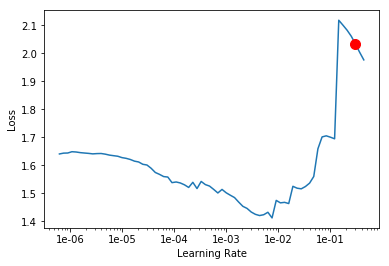

In [33]:
learner.recorder.plot(skip_end=10,suggestion=True)

We will pick a value a bit before the minimum, where the loss still improves. Here 2e^-3 seems to be a good value.

Next we will use ``fit_one_cycle`` with the chosen learning rate as the maximum learning rate. 

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.947912,0.887260,0.633090,0.366910,02:17


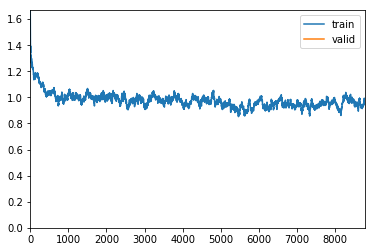

In [34]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [35]:
learner.save('first_cycle')

In [36]:
seed_all(seed)
learner.load('first_cycle');

We then unfreeze the second group of layers and repeat the operation. This allows the classifier to train more than the rest of the layers while still allowing us to take advantage of the pretrained model.

In [37]:
learner.freeze_to(-2)

In [38]:
lr = 1e-5

Note here that we use slice to create separate learning rate for each group.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.857042,0.851596,0.648789,0.351211,02:48


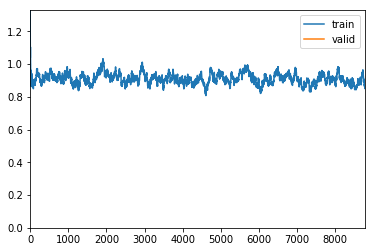

In [39]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [40]:
learner.save('second_cycle')

In [41]:
seed_all(seed)
learner.load('second_cycle');

In [42]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.814773,0.818352,0.660836,0.339164,03:18


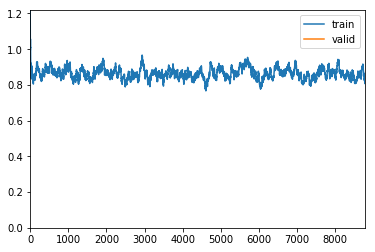

In [43]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [44]:
learner.save('third_cycle')

In [45]:
seed_all(seed)
learner.load('third_cycle');

Here, we unfreeze all the groups.

In [46]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.724594,0.744524,0.686275,0.313726,05:51
1,0.651026,0.719874,0.699667,0.300333,05:46


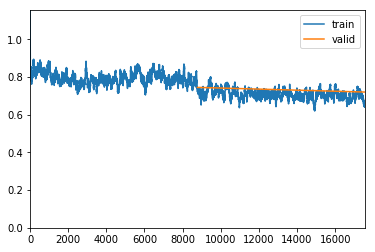

In [47]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

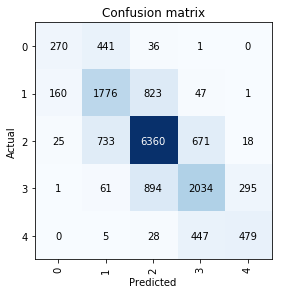

In [48]:
from fastai.tabular import *

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

Now, you can predict examples with:

In [49]:
learner.predict('This is the best movie of 2020')

(Category 4,
 tensor(4),
 tensor([1.5993e-04, 1.3484e-04, 6.1763e-03, 1.0985e-01, 8.8368e-01]))

In [50]:
learner.predict('This is the worst movie of 2020')

(Category 0,
 tensor(0),
 tensor([9.2356e-01, 7.5620e-02, 8.1824e-04, 1.5458e-06, 2.5718e-09]))

## Export Learner
In order to export and load the learner you can do these operations:

In [51]:
learner.export(file = 'transformer.pkl');

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CustomTransformerModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DistilBertForSequenceClassification. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DistilBertModel. It won't be checked for correctness upon loading.
  "type " + obj.__na

In [52]:
path = '/kaggle/working'
export_learner = load_learner(path, file = 'transformer.pkl')

As mentioned [here](https://docs.fast.ai/basic_train.html#load_learner), you have to be careful that each custom classes - like ``TransformersVocab`` - are first defined before executing ``load_learner``.

In [53]:
export_learner.predict('This is the worst movie of 2020')

(Category 0,
 tensor(0),
 tensor([9.2356e-01, 7.5620e-02, 8.1824e-04, 1.5458e-06, 2.5718e-09]))

## Creating prediction
Now that the model is trained, we want to generate predictions from the test dataset.

As specified in Keita Kurita's [article](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/), as the function ``get_preds`` does not return elements in order by default, you will have to resort the elements into their correct order.

In [54]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [55]:
sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("predictions.csv", index=False)

We check the order.

In [56]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [57]:
sample_submission.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


In [58]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='predictions.csv')

We can now submit our predictions to Kaggle !  In our example, without playing too much with the parameters, we get a score of 0.70059, which leads us to the 5th position on the leaderboard! 

# Conclusion

In this NoteBook, I explain how to combine the ``transformers`` library with the beloved ``fastai`` library. It aims to make you understand where to look and modify both libraries to make them work together. Likely, it allows you to use **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and even **Gradual Unfreezing**. As a result, without even tunning the parameters, you can obtain rapidly state-of-the-art results.

This year, the transformers became an essential tool to NLP. Because of that, I think that pre-trained transformers architectures will be integrated soon to future versions of fastai. Meanwhile, this tutorial is a good starter.

I hope you enjoyed this first article and found it useful. 
Thanks for reading and don't hesitate in leaving questions or suggestions.


# References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)